# Cifar-10 : Computer Vision Transfer Learning

In [50]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.keras.ops as ops
import pandas as pd

import random

import pickle
from sklearn.metrics import confusion_matrix
import itertools

In [2]:
(data_train, data_test, data_val), infos = tfds.load('cifar10',split=['train[:48000]','train[48000:]+test[:4000]','test[4000:]'], shuffle_files=True, # 80/10/10%
                      as_supervised=True, with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cifar10/incomplete.2TKNMZ_3.0.2/cifar10-train.tfrecord*...:   0%|         …

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cifar10/incomplete.2TKNMZ_3.0.2/cifar10-test.tfrecord*...:   0%|          …

Dataset cifar10 downloaded and prepared to /root/tensorflow_datasets/cifar10/3.0.2. Subsequent calls will reuse this data.


In [3]:
# Preprocessing data : ensure they all have the same size (32x32x3), datas are scaled [0,1] and type float32
resize_rescale = tf.keras.Sequential([
    tf.keras.layers.Resizing(32,32),
    tf.keras.layers.Rescaling(1./255)
])

def preprocess(data, augment=False) :
  data = data.shuffle(buffer_size=1000) #Shuffle data

  data=data.map(lambda x, y: (resize_rescale(x), y), num_parallel_calls=tf.data.AUTOTUNE) #Resize, rescale

  data=data.batch(64) # Batch

  return data.prefetch(buffer_size=tf.data.AUTOTUNE)

In [4]:
batch_train=preprocess(data_train)
batch_test=preprocess(data_test)
batch_val=preprocess(data_val)
batch_train, batch_test, batch_val

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 32, 32, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 32, 32, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 32, 32, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

In [5]:
# Enable mixed precision training : Better use of GPU's Memory by using lfoat32 and float16 when possible
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')

In [6]:
mixed_precision.global_policy()

<DTypePolicy "mixed_float16">

In [7]:
# Callbacks :

checkpoint_path="best_model_tl_cifar10.weights.h5"

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1)

LrReducer = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, verbose=1, min_lr=1e-7) # Only when the val_loss doesn't go down for 2 epochs

checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, monitor='val_accuracy', verbose=0, save_best_only=True, save_weights_only=True, mode='max')

In [8]:
# Turn off all warnings except for errors
tf.get_logger().setLevel('ERROR')

## Feature extraction :

In [9]:
from tensorflow.keras import layers

input_shape = (32, 32, 3)
base_model = tf.keras.applications.ResNet152(include_top=False)
base_model.trainable = False # freeze layers

inputs = layers.Input(shape=input_shape, name="input_layer")
x = base_model(inputs, training=False) # set base_model to inference mode only. Batch norm and droupout don't change their learning.
x = layers.GlobalAveragePooling2D(name="pooling_layer")(x)
x = layers.Dense(10)(x)
outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x)
model_0 = tf.keras.Model(inputs, outputs)

# Compile the model
model_0.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

234698864/234698864 ━━━━━━━━━━━━━━━━━━━━ 11s 0us/step


In [10]:
model_0.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ resnet152 (Functional)               │ (None, 1, 1, 2048)          │      58,370,944 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pooling_layer                        │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 10)                  │          20,490 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ cast_1 (Cast)                        │ (None, 10)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ softmax_float32 (Activation)         │ (None, 10)                  │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 58,391,434 (222.75 MB)

 Trainable params: 20,490 (80.04 KB)

 Non-trainable params: 58,370,944 (222.67 MB)

In [11]:
# Fit the model with callbacks
history_feature_extraction = model_0.fit(batch_train, epochs=5, validation_data=batch_val, callbacks=[early_stop,LrReducer,checkpoint])

Epoch 1/5
750/750 ━━━━━━━━━━━━━━━━━━━━ 81s 62ms/step - accuracy: 0.1416 - loss: 2.2988 - val_accuracy: 0.2212 - val_loss: 2.1882 - learning_rate: 0.0010
Epoch 2/5
750/750 ━━━━━━━━━━━━━━━━━━━━ 18s 24ms/step - accuracy: 0.2135 - loss: 2.1711 - val_accuracy: 0.2318 - val_loss: 2.1351 - learning_rate: 0.0010
Epoch 3/5
750/750 ━━━━━━━━━━━━━━━━━━━━ 16s 22ms/step - accuracy: 0.2345 - loss: 2.1254 - val_accuracy: 0.2443 - val_loss: 2.1142 - learning_rate: 0.0010
Epoch 4/5
750/750 ━━━━━━━━━━━━━━━━━━━━ 17s 22ms/step - accuracy: 0.2495 - loss: 2.1009 - val_accuracy: 0.2552 - val_loss: 2.0829 - learning_rate: 0.0010
Epoch 5/5
750/750 ━━━━━━━━━━━━━━━━━━━━ 16s 21ms/step - accuracy: 0.2580 - loss: 2.0801 - val_accuracy: 0.2667 - val_loss: 2.0659 - learning_rate: 0.0010


In [12]:
res_0=model_0.evaluate(batch_test)

94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.2601 - loss: 2.0699


In [13]:
df_fe = pd.DataFrame(history_feature_extraction.history).drop(columns=['learning_rate'])
df_fe.columns=['accuracy_fe','loss_fe','val_accuracy_fe','val_loss_fe']
df_fe_acc=df_fe.loc[:,['accuracy_fe','val_accuracy_fe']]
df_fe_loss=df_fe.loc[:,['loss_fe','val_loss_fe']]

<Axes: >

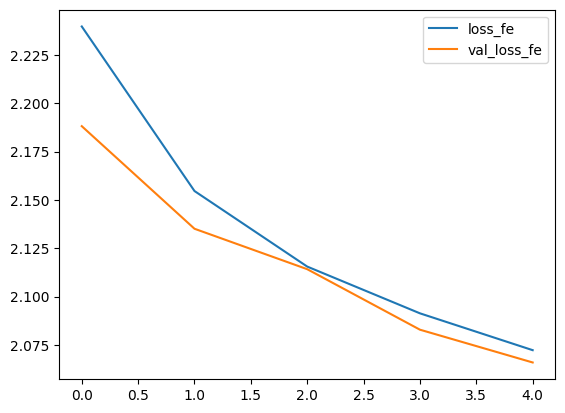

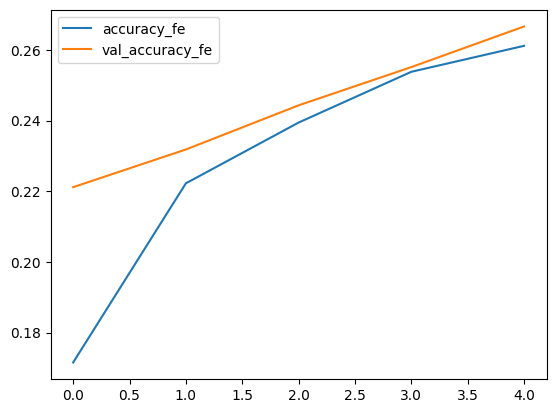

In [14]:
df_fe_loss.plot() #Plot loss

df_fe_acc.plot() #Plot acc

In [15]:
# Fit for another 5 epochs starting from the last (5th).
history_fe_2 = model_0.fit(batch_train, epochs=10, validation_data=batch_val, callbacks=[checkpoint,LrReducer,early_stop], initial_epoch=history_feature_extraction.epoch[-1]+1)

Epoch 6/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 17s 23ms/step - accuracy: 0.2653 - loss: 2.0665 - val_accuracy: 0.2685 - val_loss: 2.0563 - learning_rate: 0.0010
Epoch 7/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 21s 24ms/step - accuracy: 0.2625 - loss: 2.0569 - val_accuracy: 0.2707 - val_loss: 2.0511 - learning_rate: 0.0010
Epoch 8/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 19s 21ms/step - accuracy: 0.2681 - loss: 2.0475 - val_accuracy: 0.2672 - val_loss: 2.0465 - learning_rate: 0.0010
Epoch 9/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 21s 22ms/step - accuracy: 0.2787 - loss: 2.0364 - val_accuracy: 0.2860 - val_loss: 2.0264 - learning_rate: 0.0010
Epoch 10/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 18s 18ms/step - accuracy: 0.2777 - loss: 2.0308 - val_accuracy: 0.2857 - val_loss: 2.0190 - learning_rate: 0.0010


In [16]:
res_0=model_0.evaluate(batch_test)

94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.2769 - loss: 2.0160


In [18]:
df_fe=pd.concat([pd.DataFrame(history_feature_extraction.history).drop(columns=['learning_rate']),pd.DataFrame(history_fe_2.history).drop(columns=['learning_rate'])])
df_fe.index=range(0,len(df_fe))
df_fe.columns=['acc_fe','loss_fe','val_acc_fe','val_loss_fe']
df_fe_acc=df_fe.loc[:,['acc_fe','val_acc_fe']]
df_fe_loss=df_fe.loc[:,['loss_fe','val_loss_fe']]

[]

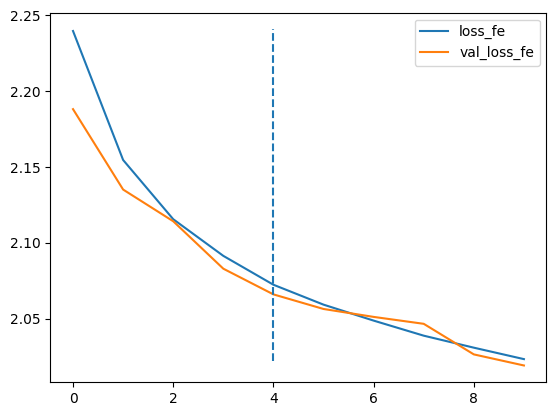

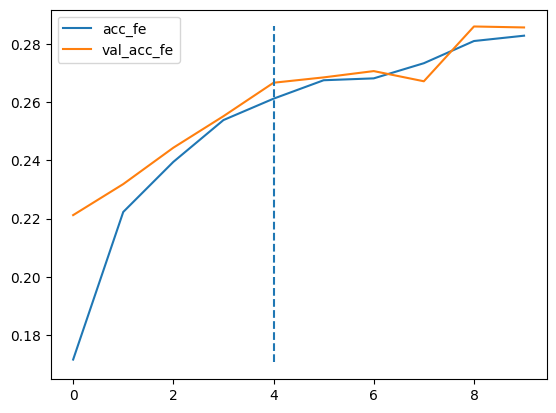

In [19]:
df_fe_loss.plot() #Plot loss
plt.vlines(4,min(df_fe['loss_fe'])-0.001,max(df_fe['loss_fe'])+0.001,linestyles='dashed')
plt.plot()

df_fe_acc.plot() #Plot acc
plt.vlines(4,min(df_fe['acc_fe'])-0.001,max(df_fe['val_acc_fe']),linestyles='dashed')
plt.plot()

## Fine-tuning :

### 10 Layers :

In [21]:
input_shape = (32, 32, 3)
base_model = tf.keras.applications.ResNet152(include_top=False)
base_model.trainable = False

# Unfreeze the last 10
for layer in base_model.layers[-10:]:
  layer.trainable = True

inputs = layers.Input(shape=input_shape, name="input_layer")
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D(name="pooling_layer")(x)
x = layers.Dense(10)(x)
outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x)
model_1 = tf.keras.Model(inputs, outputs)

# Compile the model
model_1.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

In [23]:
history_fine_tune10 = model_1.fit(batch_train, epochs=10, validation_data=batch_val, callbacks=[checkpoint,LrReducer,early_stop])

Epoch 1/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 19s 26ms/step - accuracy: 0.3823 - loss: 1.7602 - val_accuracy: 0.1220 - val_loss: 4.4847 - learning_rate: 0.0010
Epoch 2/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 18s 24ms/step - accuracy: 0.4139 - loss: 1.6563 - val_accuracy: 0.2240 - val_loss: 2.8327 - learning_rate: 0.0010
Epoch 3/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 16s 21ms/step - accuracy: 0.4359 - loss: 1.5944 - val_accuracy: 0.2093 - val_loss: 2.3912 - learning_rate: 0.0010
Epoch 4/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 19s 25ms/step - accuracy: 0.4557 - loss: 1.5414 - val_accuracy: 0.1527 - val_loss: 3.1288 - learning_rate: 0.0010
Epoch 5/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.4679 - loss: 1.5046
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
750/750 ━━━━━━━━━━━━━━━━━━━━ 23s 30ms/step - accuracy: 0.4679 - loss: 1.5046 - val_accuracy: 0.2063 - val_loss: 3.2454 - learning_rate: 0.0010
Epoch 6/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 28s 37ms/step - accuracy: 0.5049 - lo

In [24]:
res_1=model_1.evaluate(batch_test)

94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.4923 - loss: 1.5014


In [27]:
df_ft10=pd.DataFrame(history_fine_tune10.history).drop(columns=['learning_rate'])
df_ft10.columns=['accuracy_ft10','loss_ft10','val_accuracy_ft10','val_loss_ft10']
df_ft10_acc=df_ft10.loc[:,['accuracy_ft10','val_accuracy_ft10']]
df_ft10_loss=df_ft10.loc[:,['loss_ft10','val_loss_ft10']]

<Axes: >

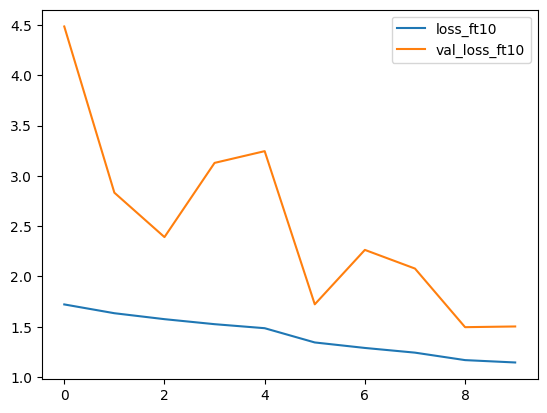

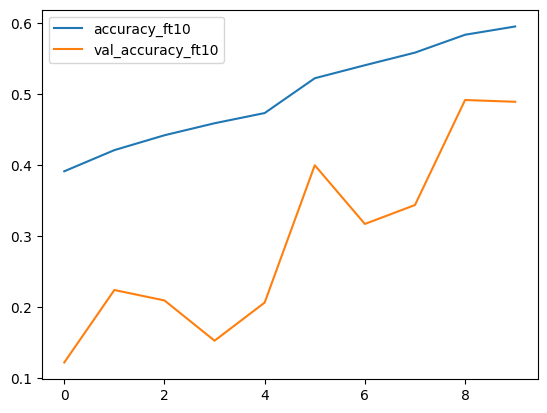

In [28]:
df_ft10_loss.plot() #Plot loss
df_ft10_acc.plot() #Plot acc

### 25 layers :

In [30]:
input_shape = (32, 32, 3)
base_model = tf.keras.applications.ResNet152(include_top=False)
base_model.trainable = False

# Unfreeze the last 25 :
for layer in base_model.layers[-25:]:
  layer.trainable = True

inputs = layers.Input(shape=input_shape, name="input_layer")
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D(name="pooling_layer")(x)
x = layers.Dense(10)(x)
outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x)
model_2 = tf.keras.Model(inputs, outputs)

# Compile the model
model_2.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

In [31]:
history_fine_tune25 = model_2.fit(batch_train, epochs=15, validation_data=batch_val, callbacks=[checkpoint,LrReducer,early_stop])

Epoch 1/15
750/750 ━━━━━━━━━━━━━━━━━━━━ 85s 48ms/step - accuracy: 0.2756 - loss: 2.2130 - val_accuracy: 0.0973 - val_loss: 8.7203 - learning_rate: 0.0010
Epoch 2/15
750/750 ━━━━━━━━━━━━━━━━━━━━ 19s 25ms/step - accuracy: 0.3951 - loss: 1.8517 - val_accuracy: 0.2763 - val_loss: 2.7441 - learning_rate: 0.0010
Epoch 3/15
750/750 ━━━━━━━━━━━━━━━━━━━━ 19s 24ms/step - accuracy: 0.4280 - loss: 1.7213 - val_accuracy: 0.2758 - val_loss: 3.9381 - learning_rate: 0.0010
Epoch 4/15
750/750 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.4509 - loss: 1.6252
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
750/750 ━━━━━━━━━━━━━━━━━━━━ 18s 24ms/step - accuracy: 0.4509 - loss: 1.6251 - val_accuracy: 0.2317 - val_loss: 2.8406 - learning_rate: 0.0010
Epoch 5/15
750/750 ━━━━━━━━━━━━━━━━━━━━ 18s 23ms/step - accuracy: 0.4859 - loss: 1.4530 - val_accuracy: 0.4288 - val_loss: 1.7109 - learning_rate: 2.0000e-04
Epoch 6/15
750/750 ━━━━━━━━━━━━━━━━━━━━ 18s 24ms/step - accuracy: 0.5122 

In [32]:
res_2=model_2.evaluate(batch_test)

94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.4924 - loss: 1.4861


In [33]:
df_ft25=pd.DataFrame(history_fine_tune25.history).drop(columns=['learning_rate'])
df_ft25.columns=['accuracy_ft25','loss_ft25','val_accuracy_ft25','val_loss_ft25']
df_ft25_acc=df_ft25.loc[:,['accuracy_ft25','val_accuracy_ft25']]
df_ft25_loss=df_ft25.loc[:,['loss_ft25','val_loss_ft25']]

<Axes: >

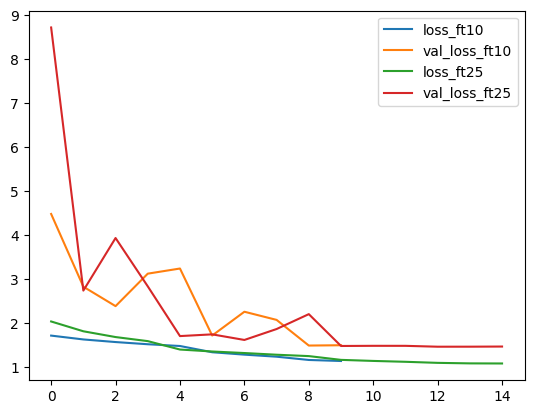

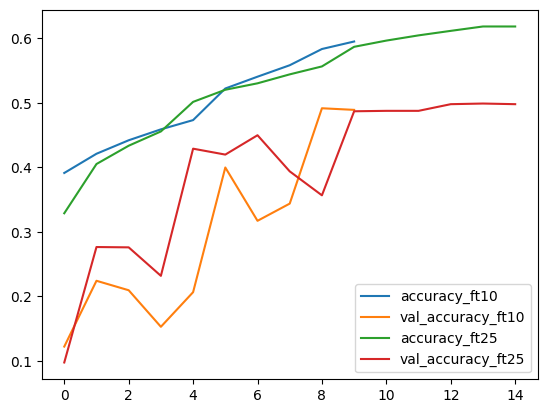

In [36]:
pd.concat([df_ft10_loss,df_ft25_loss]).plot() #Plot loss
pd.concat([df_ft10_acc,df_ft25_acc]).plot() #Plot acc

### 50 layers :

In [37]:
input_shape = (32, 32, 3)
base_model = tf.keras.applications.ResNet152(include_top=False)
base_model.trainable = False

# Unfreeze the last 50 :
for layer in base_model.layers[-50:]:
  layer.trainable = True

inputs = layers.Input(shape=input_shape, name="input_layer")
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D(name="pooling_layer")(x)
x = layers.Dense(10)(x)
outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x)
model_3 = tf.keras.Model(inputs, outputs)

# Compile the model
model_3.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

In [38]:
history_fine_tune50 = model_3.fit(batch_train, epochs=15, validation_data=batch_val,callbacks=[checkpoint,LrReducer,early_stop])

Epoch 1/15
750/750 ━━━━━━━━━━━━━━━━━━━━ 95s 48ms/step - accuracy: 0.2859 - loss: 2.3498 - val_accuracy: 0.0952 - val_loss: 146.4071 - learning_rate: 0.0010
Epoch 2/15
750/750 ━━━━━━━━━━━━━━━━━━━━ 19s 25ms/step - accuracy: 0.4070 - loss: 1.8691 - val_accuracy: 0.1013 - val_loss: 733.3274 - learning_rate: 0.0010
Epoch 3/15
748/750 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.4436 - loss: 1.7553
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
750/750 ━━━━━━━━━━━━━━━━━━━━ 22s 27ms/step - accuracy: 0.4437 - loss: 1.7551 - val_accuracy: 0.0985 - val_loss: 1881.1687 - learning_rate: 0.0010
Epoch 4/15
750/750 ━━━━━━━━━━━━━━━━━━━━ 20s 27ms/step - accuracy: 0.4856 - loss: 1.5288 - val_accuracy: 0.2315 - val_loss: 4.6763 - learning_rate: 2.0000e-04
Epoch 5/15
750/750 ━━━━━━━━━━━━━━━━━━━━ 20s 27ms/step - accuracy: 0.5134 - loss: 1.3873 - val_accuracy: 0.1140 - val_loss: 21.0537 - learning_rate: 2.0000e-04
Epoch 6/15
748/750 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accura

In [39]:
res_3=model_3.evaluate(batch_test)

94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.5009 - loss: 1.4530


In [40]:
df_ft50=pd.DataFrame(history_fine_tune50.history).drop(columns=['learning_rate'])
df_ft50.columns=['accuracy_ft50','loss_ft50','val_accuracy_ft50','val_loss_ft50']
df_ft50_acc=df_ft50.loc[:,['accuracy_ft50','val_accuracy_ft50']]
df_ft50_loss=df_ft50.loc[:,['loss_ft50','val_loss_ft50']]

<Axes: >

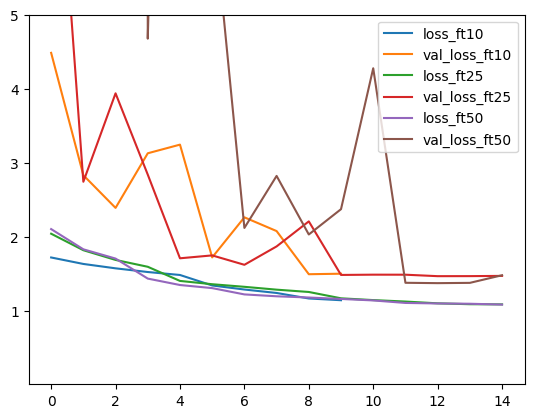

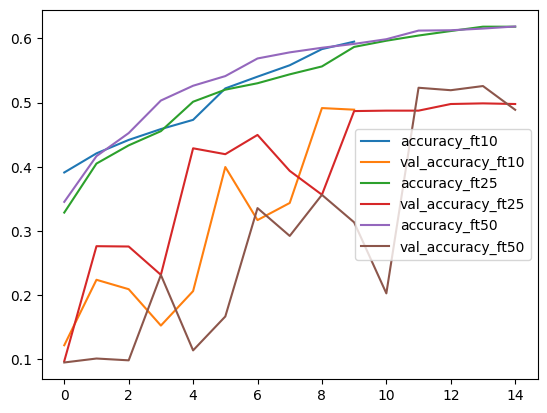

In [45]:
pd.concat([df_ft10_loss,df_ft25_loss,df_ft50_loss]).plot(ylim=(0.01,5)) #Plot loss
pd.concat([df_ft10_acc,df_ft25_acc,df_ft50_acc]).plot() #Plot acc

## Conclusion :

In [46]:
res=pd.DataFrame([res_0,res_1,res_2,res_3])
res.columns=['loss','accuracy']
res.index=['model_fe','model_ft10','model_ft25','model_ft50']

<Axes: >

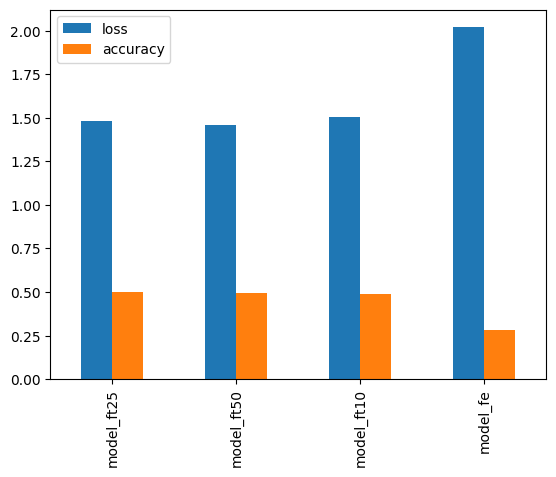

In [48]:
res.sort_values(by='accuracy',ascending=False).plot(kind='bar')

### Confusion matrix

In [49]:
# https://stackoverflow.com/questions/64622210/how-to-extract-classes-from-prefetched-dataset-in-tensorflow-for-confusion-matri

y_pred = []  # store predicted labels
y_true = []  # store true labels

# iterate over the dataset
for image_batch, label_batch in batch_test:   # use dataset.unbatch() with repeat
   # append true labels
   y_true.append(label_batch)
   # compute predictions
   preds = model_2.predict(image_batch,verbose=0)
   # append predicted labels
   y_pred.append(np.argmax(preds, axis = 1))

# convert the true and predicted labels into tensors
correct_labels = tf.concat([item for item in y_true], axis = 0)
predicted_labels = tf.concat([item for item in y_pred], axis = 0)

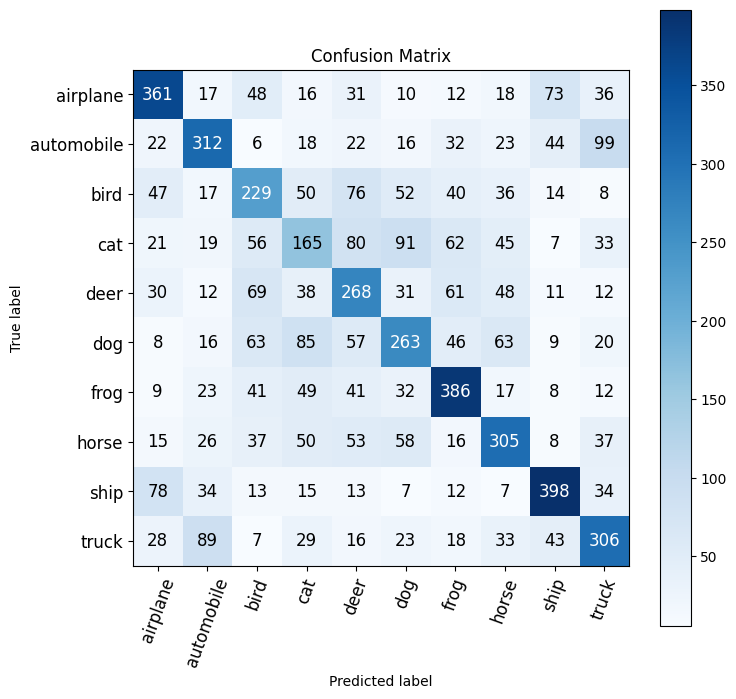

In [51]:
# https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/06_transfer_learning_in_tensorflow_part_3_scaling_up.ipynb

n_classes=len(infos.features['label'].names)

cm = confusion_matrix(correct_labels, predicted_labels)

# Plot the figure and make it pretty
fig, ax = plt.subplots(figsize=(8,8))
cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
fig.colorbar(cax)

# Label the axes
ax.set(title="Confusion Matrix",
        xlabel="Predicted label",
        ylabel="True label",
        xticks=np.arange(n_classes), # create enough axis slots for each class
        yticks=np.arange(n_classes),
        xticklabels=infos.features['label'].names,
        yticklabels=infos.features['label'].names)

# Make x-axis labels appear on bottom
ax.xaxis.set_label_position("bottom")
ax.xaxis.tick_bottom()

### Added: Rotate xticks for readability & increase font size (required due to such a large confusion matrix)
plt.xticks(rotation=70, fontsize=12)
plt.yticks(fontsize=12)

# Set the threshold for different colors
threshold = (cm.max() + cm.min()) / 2.

# Plot the text on each cell
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
  plt.text(j, i, f"{cm[i, j]}",
          ha="center",
          va='center',
          color="white" if cm[i, j] > threshold else "black",
          size=12)